## # ECE 9039 Final Project - MULTI-CLASS MUSIC GENRE CLASSIFICATION
### Contributors:
- Chukwuemeka Momodu
- Damilola Awotunde

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# keras
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras import callbacks
from keras import Input # for instantiating a keras tensor

# metrics
from sklearn.metrics import log_loss, confusion_matrix, precision_recall_fscore_support, accuracy_score, f1_score

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier


from sklearn.metrics import make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

from sklearn.utils import class_weight

2023-04-09 00:32:04.075048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 00:32:04.268945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-09 00:32:04.268967: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-09 00:32:05.045492: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
# read dataset into pandas dataframe
data = pd.read_csv('./data/data.csv')
# save copy of data
original_data_copy = data.copy()

In [3]:
# print data shape
print("Dataset shape is: {0}".format(data.shape))

Dataset shape is: (17996, 17)


In [4]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [5]:
# view top 5 rows of dataset
data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [6]:
# target column
target_col = 'Class'
# feature columns
feature_cols = []
for column in data.select_dtypes(exclude=["object"]).columns: # exclude Artist Name and Track Name columns with object dtype
    if column != 'Class': feature_cols.append(column) # exclude target variable
print("\nTarget column: {0}".format(target_col))
print("\nFeature columns: {0}".format(feature_cols))
print("\nNo of Features: {0}".format(len(feature_cols)))


Target column: Class

Feature columns: ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature']

No of Features: 14


## Exploratory Data Analysis (EDA)

                                   Visualising Target Column:                                   


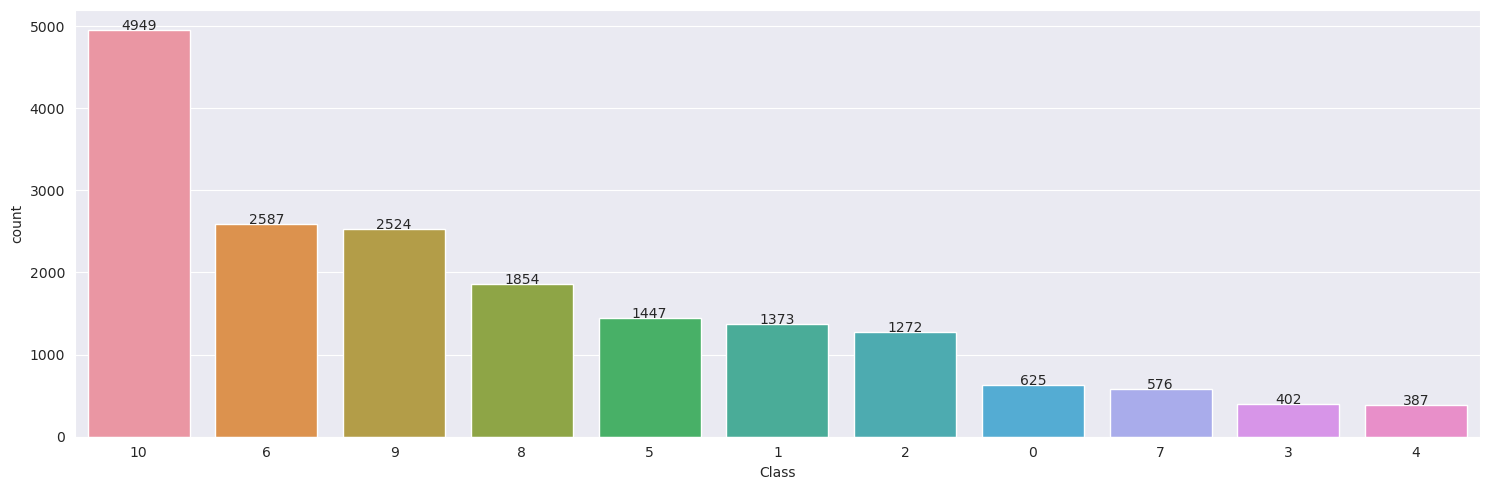

In [7]:
# Visualising the Target Column
print('\033[1mVisualising Target Column:'.center(100))
plt.figure(figsize=[15,5])
sns.countplot(x=data[target_col], order=data[target_col].value_counts().index)
plt.tight_layout()

# Get the count of occurrences for each category in the "target_col" column
counts = data[target_col].value_counts()

# Add count values on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v+1, str(v), ha="center")

plt.show()

In [8]:
# number of observations for each class in the train set
print("Number of observations for each class in data")
value_counts = data[target_col].value_counts()
for i in range(len(value_counts)):
    print("Class {0}: {1}".format(i, value_counts[i]))

Number of observations for each class in data
Class 0: 625
Class 1: 1373
Class 2: 1272
Class 3: 402
Class 4: 387
Class 5: 1447
Class 6: 2587
Class 7: 576
Class 8: 1854
Class 9: 2524
Class 10: 4949


In [9]:
# Find all categorical features with the condition of less than 50 unique value
categorical_cols_dict = {}
cat_cols_list = []
non_cat_cols_list = []
for column in feature_cols:
    num_unique_values = len(data[column].unique())
    if num_unique_values < 50:
        categorical_cols_dict[column] = num_unique_values
        cat_cols_list.append(column)
    else: non_cat_cols_list.append(column) # find non-categorical features

print("Categorical columns and number of classes\n")
print(pd.DataFrame({'Column': categorical_cols_dict.keys(), 'No of Classes': categorical_cols_dict.values()}))

Categorical columns and number of classes

           Column  No of Classes
0             key             12
1            mode              2
2  time_signature              4


                                Visualising Categorical Columns:                                


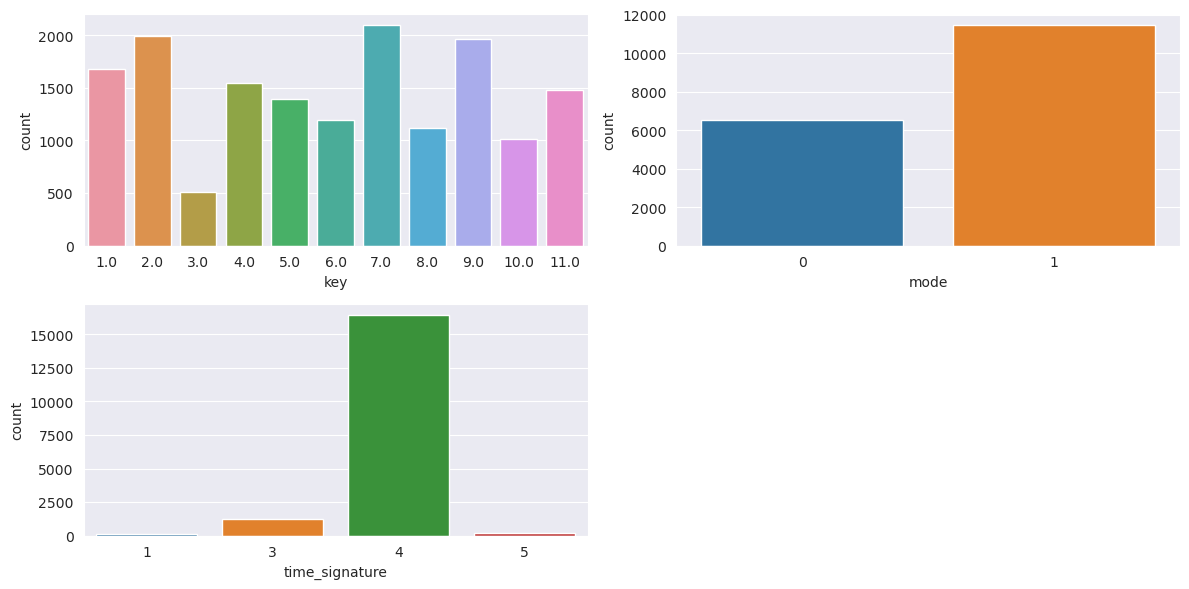

In [10]:
# Visualising the categorical Columns
print('\033[1mVisualising Categorical Columns:'.center(100))
n=2
cf = cat_cols_list
df = data
plt.figure(figsize=[12,3*math.ceil(len(cf)/n)])
for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n),n,i+1)
    sns.countplot(df[cf[i]])
plt.tight_layout()
plt.show()

                              Non-Categorical Columns Distribution                              


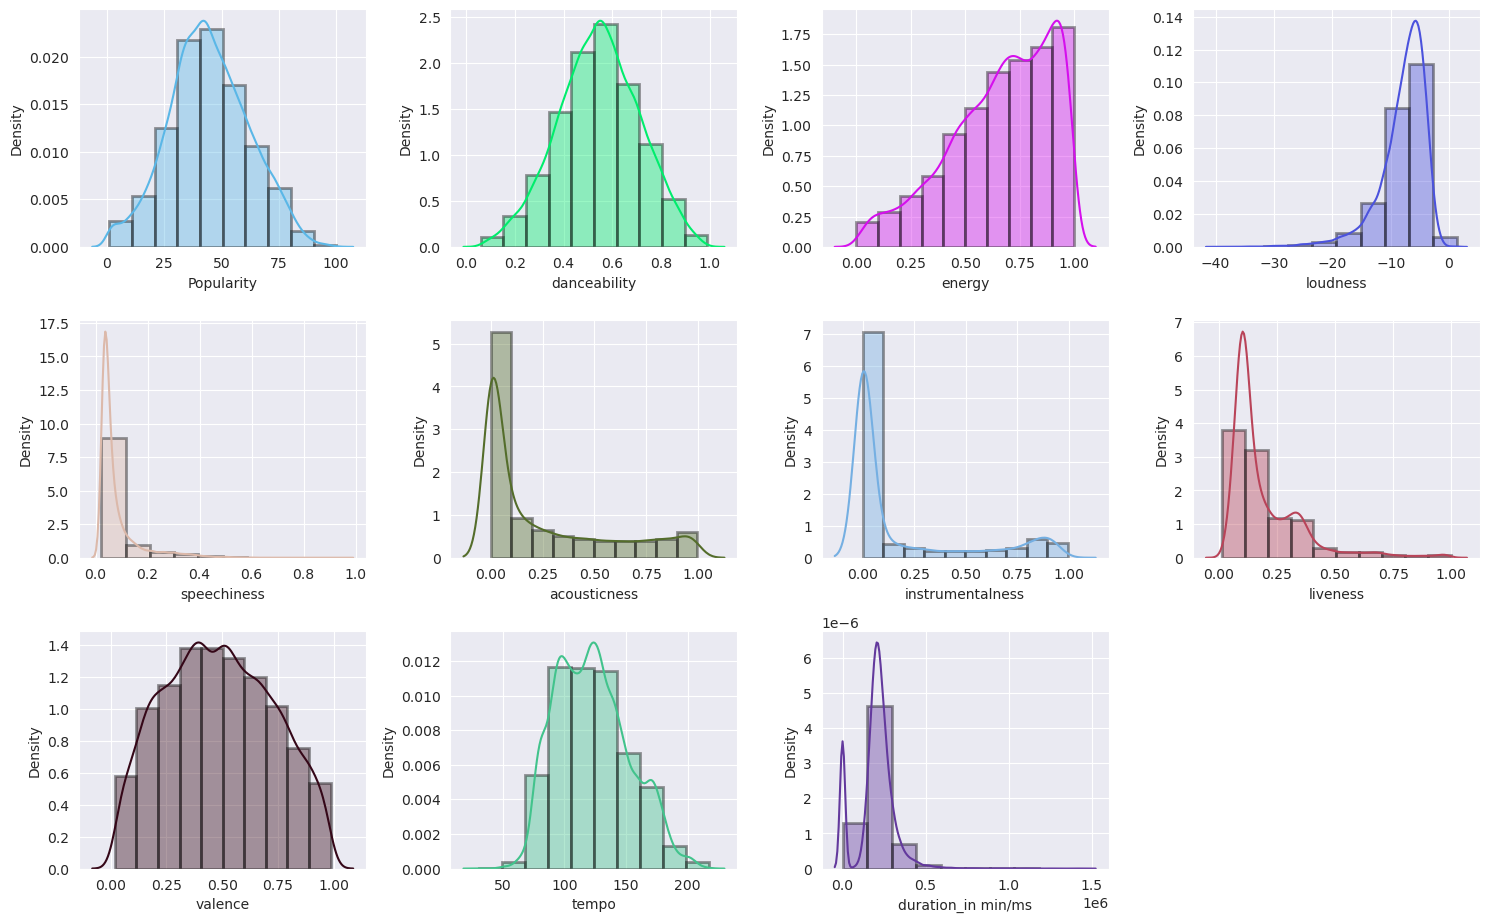

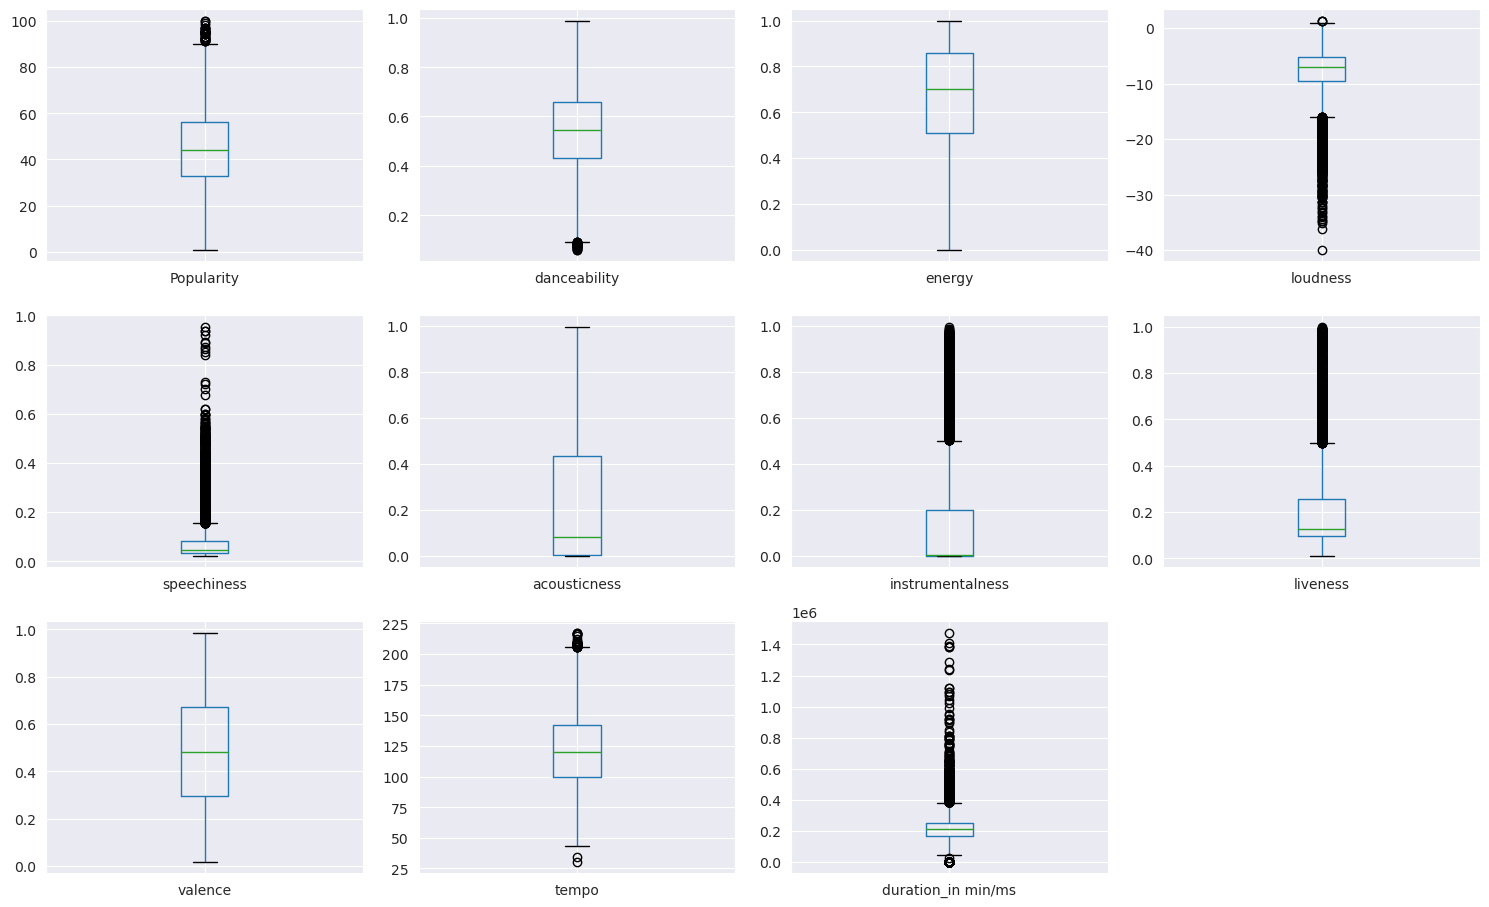

In [11]:
# Visualising the non-categorical columns
print('\033[1mNon-Categorical Columns Distribution'.center(100))
nf = non_cat_cols_list
n=4
clr=['r','g','b','g','b','r']
# plot distribution
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(data[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()
# box plot
plt.figure(figsize=[15,4*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    data.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers as well as large scaled features. This would be fixed in the pre-processing step

                                       Correlation Matrix                                       


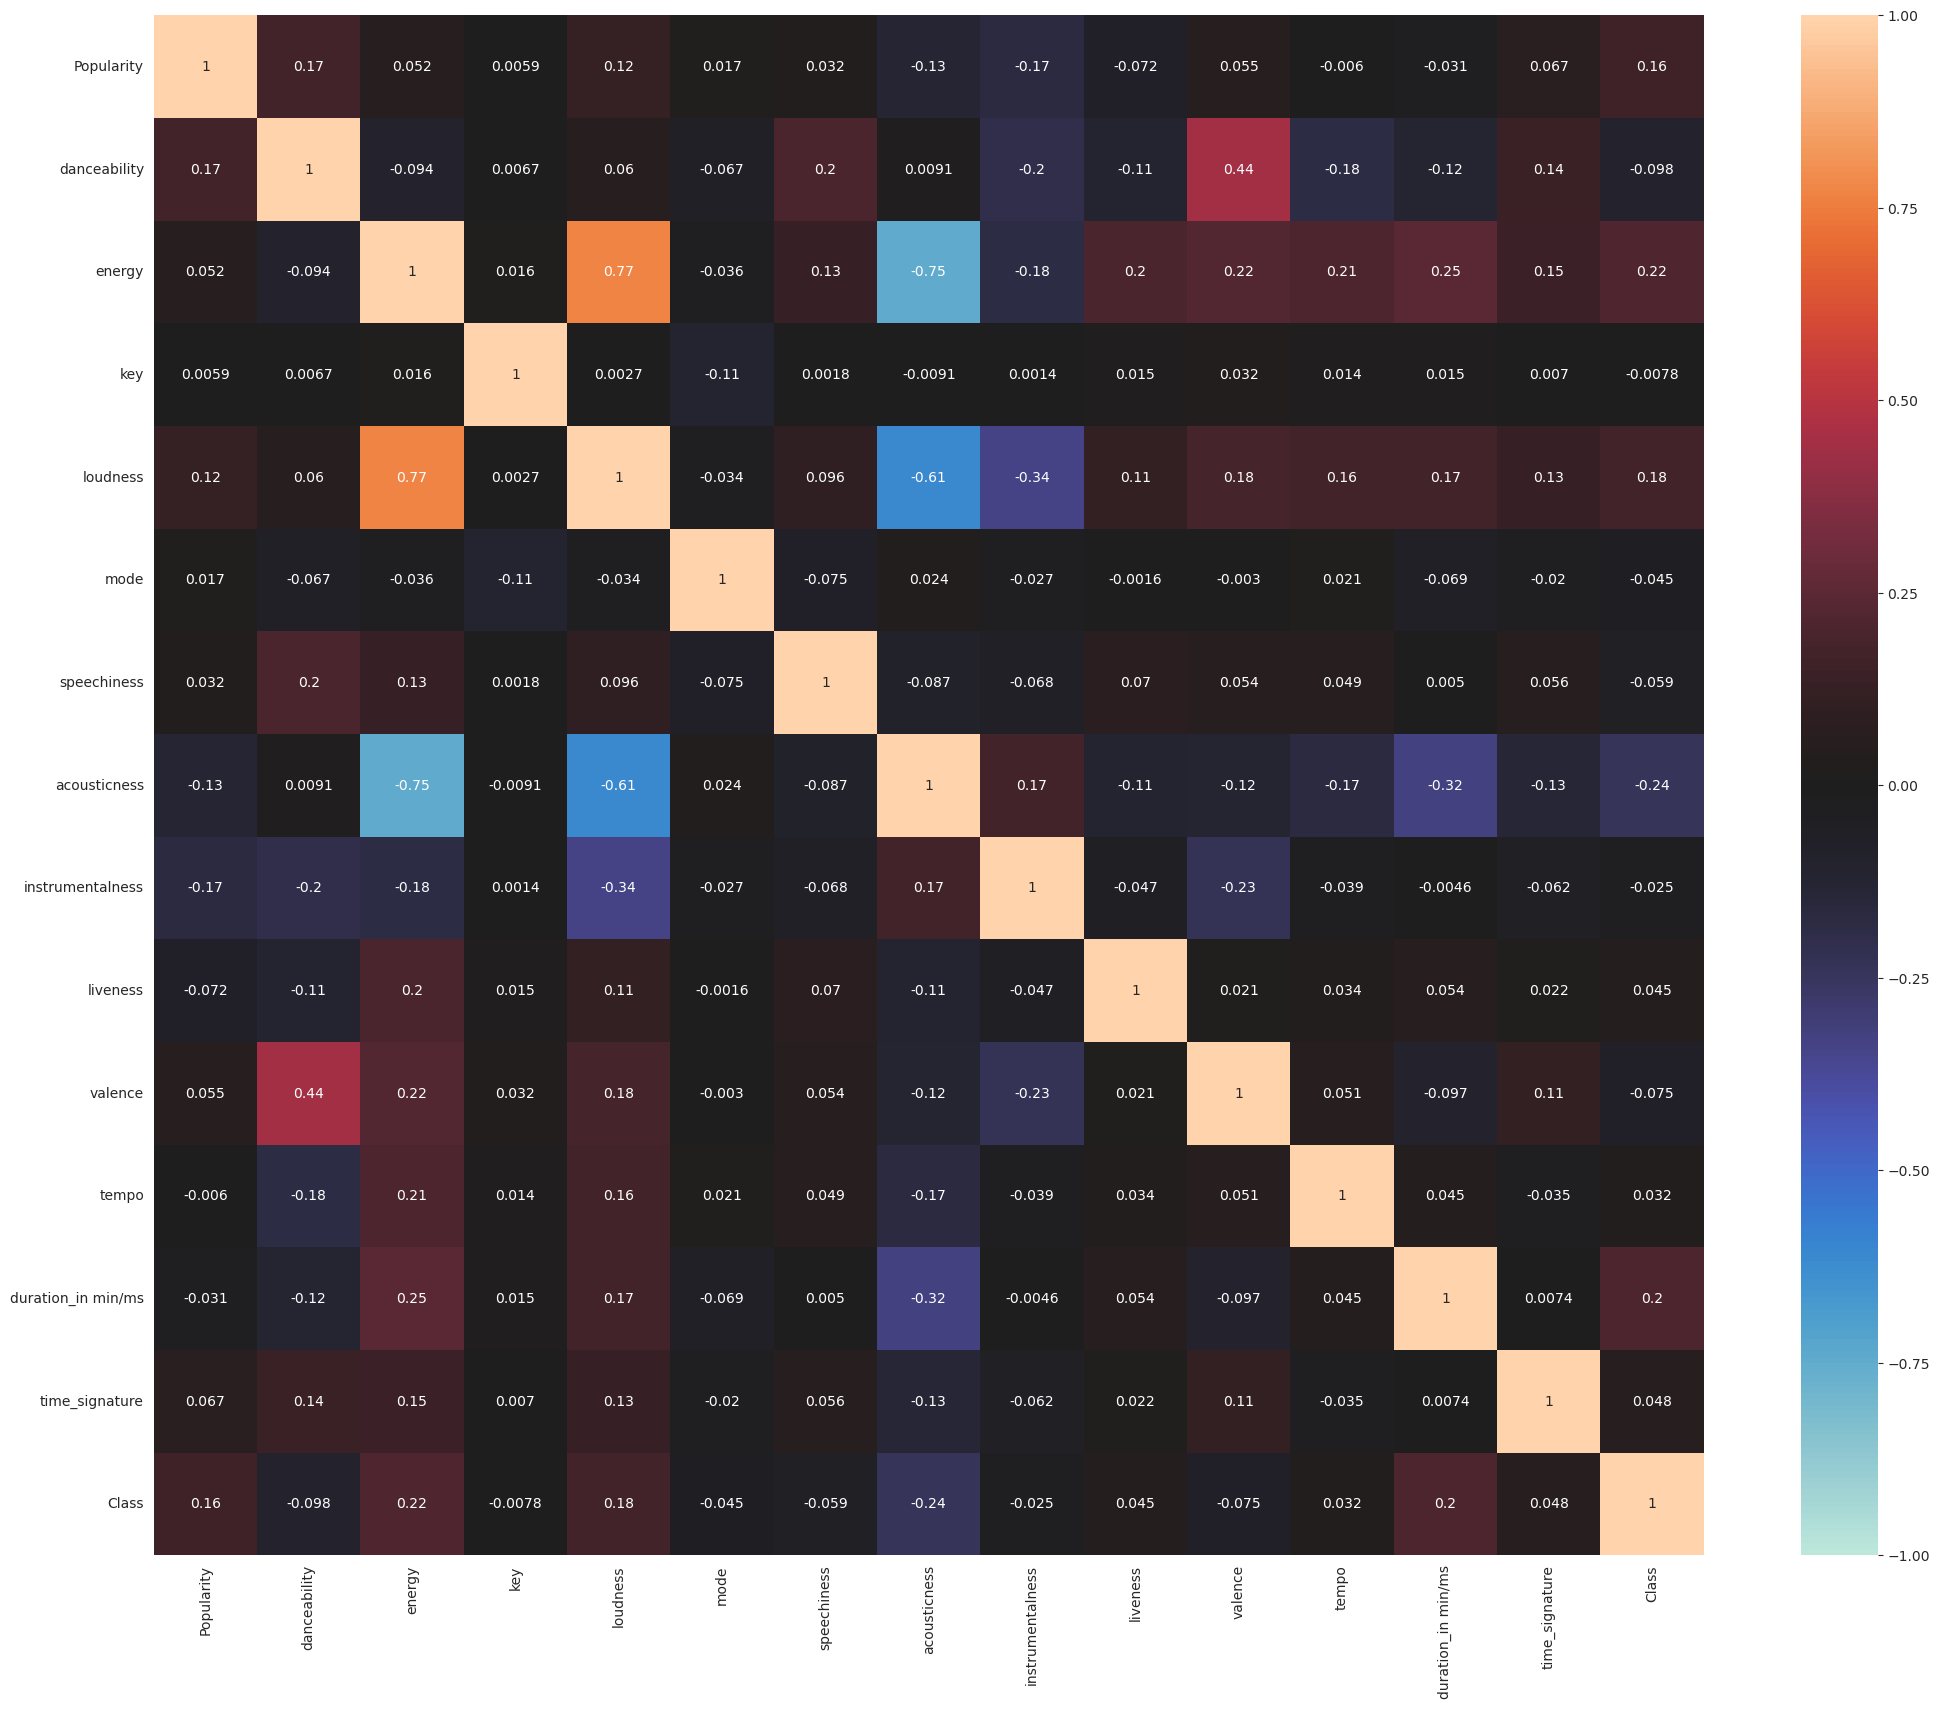

In [12]:
# Checking the correlation
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(data.select_dtypes(exclude=["object"]).corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

Inference: There seems to be some high multi-correlation between the features. Skipping these for now, as the advanced ML Algorithms take care of multicollinearity.

## Data Pre-processing

In [13]:
# Show count and percentage of missing values in columns
print("Columns null value count and percentage\n")
nvc = pd.DataFrame(data.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/data.shape[0],3)*100
print(nvc)

Columns null value count and percentage

                    Total Null Values  Percentage
Artist Name                         0         0.0
duration_in min/ms                  0         0.0
tempo                               0         0.0
valence                             0         0.0
liveness                            0         0.0
acousticness                        0         0.0
time_signature                      0         0.0
speechiness                         0         0.0
loudness                            0         0.0
energy                              0         0.0
danceability                        0         0.0
Track Name                          0         0.0
mode                                0         0.0
Class                               0         0.0
Popularity                        428         2.4
key                              2014        11.2
instrumentalness                 4377        24.3


In [14]:
# handling missing values

# "Popularity" column is non-categorical and has 2% null values which is relatively small
# hence replacing null values with the mean
# Create a SimpleImputer object
mean_imputer = SimpleImputer(strategy="mean")
data['Popularity'] = mean_imputer.fit_transform(data[['Popularity']])

In [15]:
# "key" column is categorical and has 11% null values which is relatively small
# hence replacing null values with the mode

mode_imputer = SimpleImputer(strategy="most_frequent")
data['key'] = mode_imputer.fit_transform(data[['key']])

In [16]:
#"instrumentalness" column has relatively substantial amount of missing values (24%)
# hence using KNN to predict missing values

# Create a KNN imputer object with k=5
knn_imputer = KNNImputer(n_neighbors=5)

# Replace null values in "instrumentalness" column with KNN imputation
columns_to_impute = ["instrumentalness"]
data[columns_to_impute] = knn_imputer.fit_transform(data[columns_to_impute])

In [17]:
# confirm all missing values have been handled
data.isnull().sum()

Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64

In [18]:
# Removal of any Duplicate rows (if any)
data_copy_duplicates = data.copy()
counter = 0
rs,cs = data_copy_duplicates.shape

data.drop_duplicates(inplace=True)

if data.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-data.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [19]:
# # """
# # Removal of outlier:
#
# data_copy_outliers = data.copy()
#
# # The code calculates the first and third quartiles (Q1 and Q3) and the interquartile range (IQR) using the quantile() method.
# # The IQR is then used to identify the outliers: any data point whose value is above Q3 + 1.5*IQR or below Q1 - 1.5*IQR is considered an outlier.
# for i in feature_cols:
#     Q1 = data[i].quantile(0.25)
#     Q3 = data[i].quantile(0.75)
#     IQR = Q3 - Q1
#     data = data[data[i] <= (Q3+(1.5*IQR))]
#     data = data[data[i] >= (Q1-(1.5*IQR))]
#     data = data.reset_index(drop=True)
#
# print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(data_copy_outliers.shape[0]))
# print('After removal of outliers, The dataset now has {} samples.'.format(data.shape[0]))
# # """

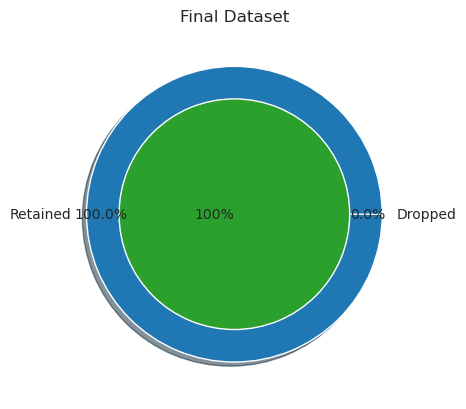


Observation: After the cleanup process, 0 samples were dropped, while retaining 100.0% of the data.


In [20]:
# Final Dataset size after performing Preprocessing

plt.title('Final Dataset')
plt.pie([data.shape[0], original_data_copy.shape[0]-data.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([data.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mObservation:\033[0m After the cleanup process, {original_data_copy.shape[0]-data.shape[0]} samples were dropped, \
while retaining {round((data.shape[0]*100/(original_data_copy.shape[0])),2)}% of the data.')

## Feature Selection and Engineering

In [21]:
# apply one-hot encoding on "mode" and "time_signature" because they are categorical features with 5 or fewer classes
features_df = data[feature_cols]
features_df_oh = pd.get_dummies(features_df, columns=['time_signature', 'mode'])
print("New number of features: {0}".format(len(features_df_oh.columns)))
print("\nFEATURES :")
for i in range(len(features_df_oh.columns)):
    print("{0}. {1}".format(i+1, features_df_oh.columns[i]))

New number of features: 18

FEATURES :
1. Popularity
2. danceability
3. energy
4. key
5. loudness
6. speechiness
7. acousticness
8. instrumentalness
9. liveness
10. valence
11. tempo
12. duration_in min/ms
13. time_signature_1
14. time_signature_3
15. time_signature_4
16. time_signature_5
17. mode_0
18. mode_1


In [22]:
# target dataframe
y = data[target_col]
# features dataframe
X = features_df_oh
# split data into train and test sets, 70% and 30% respectively, with random_state of 42, and stratify to ensure distribution is consistent in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42, shuffle=True, stratify=y)

In [23]:
# compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

## Model Training and Creation

In [24]:
# Proposed models
# LogisticRegression
# SVC
# Random Forest
# Neural network (Multi-layer Perceptron)

In [25]:
# initialise global result dataframe
logloss_results_all_df = pd.DataFrame(columns=['Model', 'Train LogLoss', 'Test LogLoss'])

precision_recall_f1_results_all_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-score'])

def calculate_train_test_logloss(ytrain, ytrain_prob, ytest, ytest_prob):
    # train validation
    # Calculate the LogLoss score for train set
    logloss_train = log_loss(ytrain, ytrain_prob)
    # test validation (generalization)
    # Calculate the LogLoss score for test set
    logloss_test = log_loss(ytest, ytest_prob)
    return logloss_train, logloss_test


In [26]:
def plot_calibration_curve(model, y_pred_prob, model_name):
    # Plot the calibration curve
    fig, ax = plt.subplots(figsize=(10, 8))
    for i in range(len(model.classes_)):
        prob_true, prob_pred = calibration_curve(y_test == model.classes_[i], y_pred_prob[:, i])
        ax.plot(prob_pred, prob_true, label=f'class {i}')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability')
    ax.set_title('{} Calibration Curve'.format(model_name))
    ax.legend()
    plt.show()

In [27]:
def plot_confusion_matrix(ytest, ypred, model_name):
    # Calculate the confusion matrix
    cm = confusion_matrix(ytest, ypred)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('{} Confusion matrix'.format(model_name))
    plt.show()

In [28]:
from sklearn.metrics import classification_report

# Logistic Regression
# create pipeline to standardize features and create a logistic regression model with max iteration of 1000
logisticRegression = Pipeline([('Standardizer', StandardScaler()), ('LogisticRegressionModel', LogisticRegression(multi_class='multinomial', penalty='l2', random_state=42, class_weight='balanced'))])
# logisticRegression = LogisticRegression(max_iter=1000)
# fit pipeline to train data with standardized features
logisticRegression.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_lr = logisticRegression.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_lr = logisticRegression.predict_proba(X_test)
# get test predictions
y_test_pred_lr = logisticRegression.predict(X_test)

                 Model  Train LogLoss  Test LogLoss
0  Logistic Regression       1.456761      1.473809


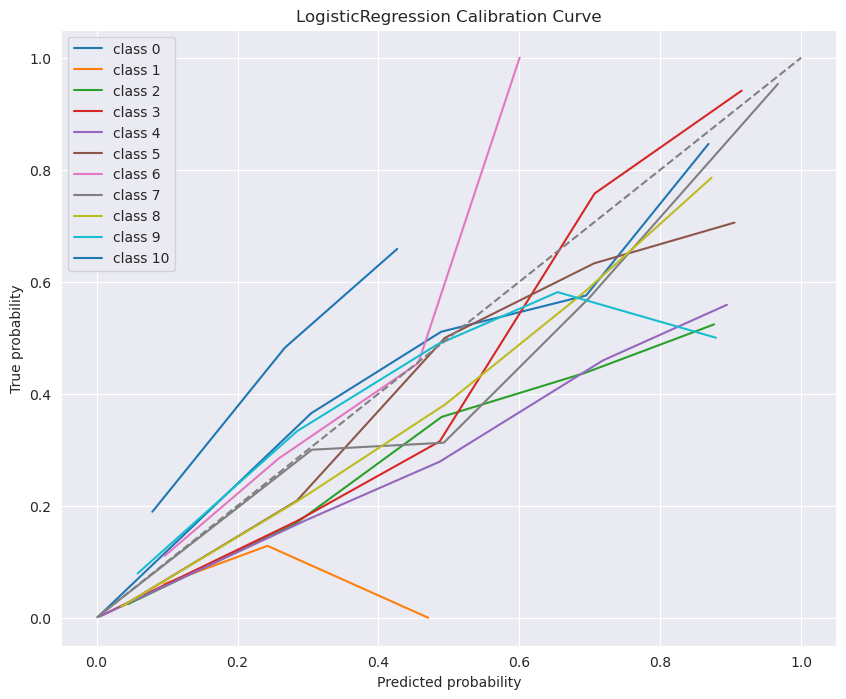

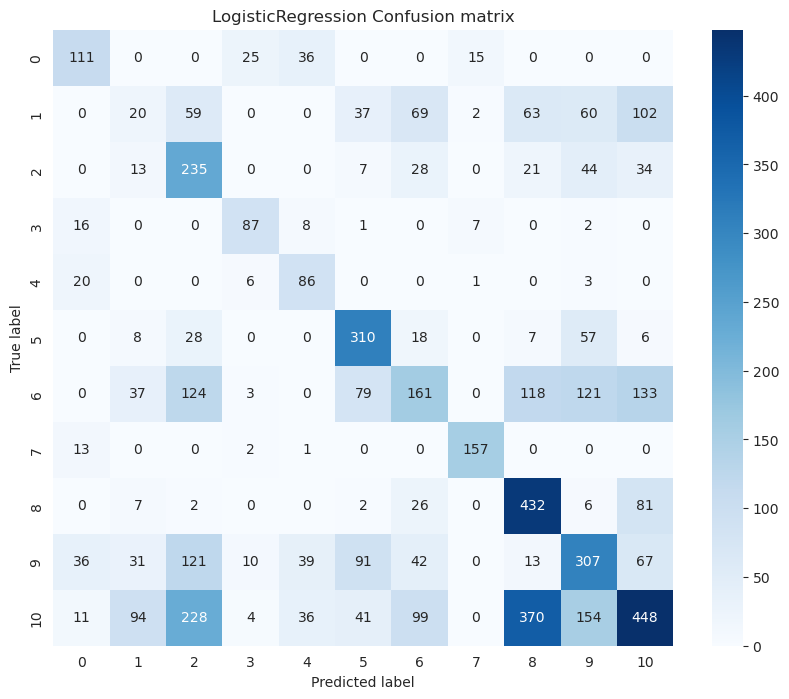

                 Model  Precision    Recall  F1-score
0  Logistic Regression   0.435661  0.436007  0.413161


In [29]:
# print logloss validation for train and test predictions
logloss_train_lr, logloss_test_lr = calculate_train_test_logloss(y_train, y_train_prob_lr, y_test, y_test_prob_lr)

# create a pandas dataframe to store the results
logloss_results_lr_dict = {'Model': ['Logistic Regression'],
                           'Train LogLoss': [logloss_train_lr],
                           'Test LogLoss': [logloss_test_lr]}
logloss_results_lr_df = pd.DataFrame(logloss_results_lr_dict)
# print logloss result
print(logloss_results_lr_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Logistic Regression',
                                                        'Train LogLoss': logloss_train_lr,
                                                        'Test LogLoss': logloss_test_lr}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(logisticRegression, y_test_prob_lr, "LogisticRegression")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_lr, "LogisticRegression")

# precision, recall, f1_score
precision_lr, recall_lr, f1_score_lr, _ = precision_recall_fscore_support(y_test, y_test_pred_lr, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_lr_dict = {'Model': ['Logistic Regression'],
                                       'Precision': [precision_lr],
                                       'Recall': [recall_lr],
                                       'F1-score': [f1_score_lr]}
precision_recall_f1__results_lr_df = pd.DataFrame(precision_recall_f1_results_lr_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_lr_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Logistic Regression',
                                                                                'Precision': precision_lr,
                                                                                'Recall': recall_lr,
                                                                                'F1-score': f1_score_lr}, ignore_index=True)

In [30]:
# Support Vector Classifier

# create pipeline to standardize features and create a Support Vector Classifier model with max iteration of 1000
svc = Pipeline([('Standardizer', StandardScaler()), ('SVC', SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'))])
# svc = SVC(max_iter=1000, kernel='rbf', probability=True)
# fit pipeline to train data minmax scaled features

svc.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_svc = svc.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_svc = svc.predict_proba(X_test)
# get test predictions
y_test_pred_svc = svc.predict(X_test)

                       Model  Train LogLoss  Test LogLoss
0  Support Vector Classifier       1.162334      1.286531


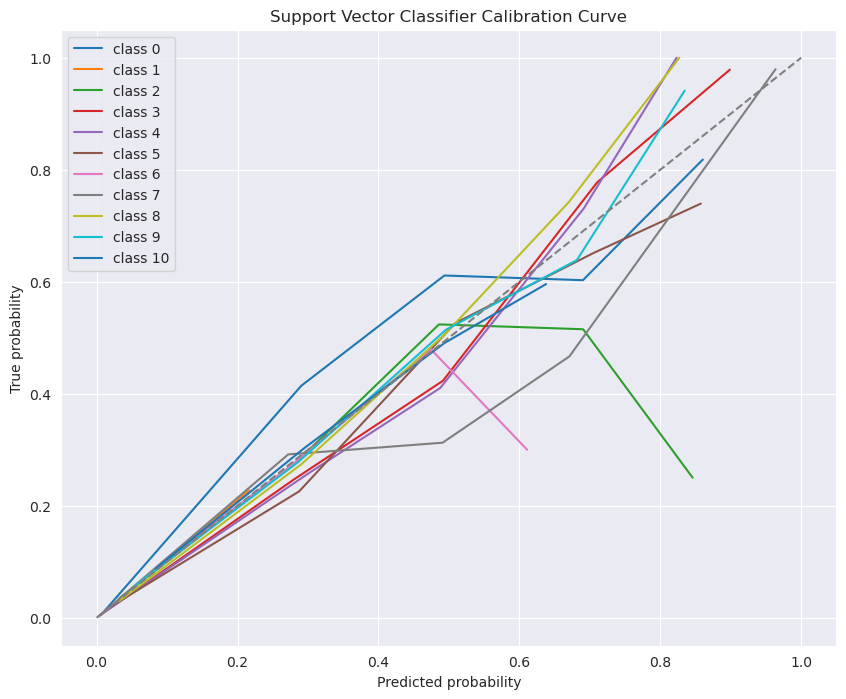

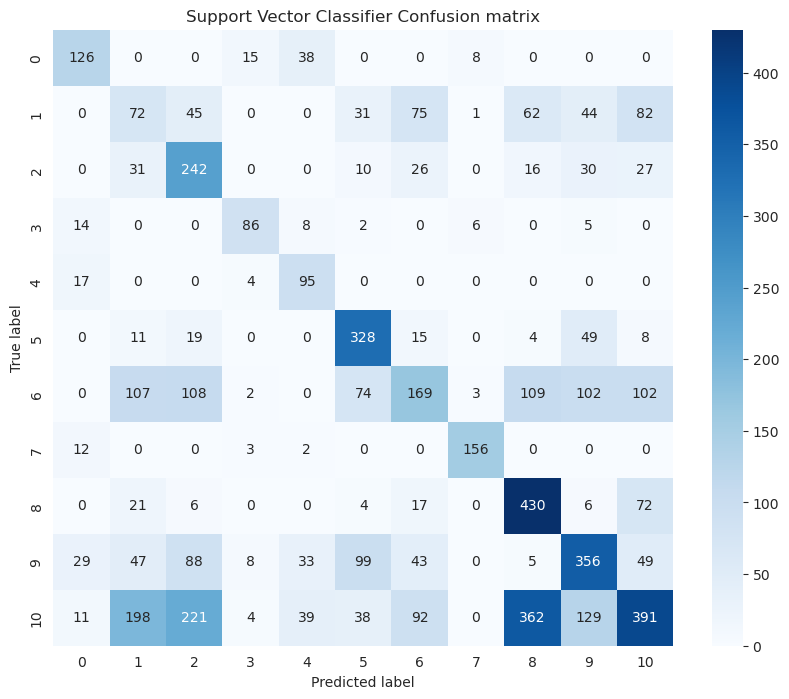

                       Model  Precision    Recall  F1-score
0  Support Vector Classifier    0.47142  0.453973  0.435811


In [31]:
# print logloss validation for train and test predictions
logloss_train_svc, logloss_test_svc = calculate_train_test_logloss(y_train, y_train_prob_svc, y_test, y_test_prob_svc)

# create a pandas dataframe to store the results
logloss_results_svc_dict = {'Model': ['Support Vector Classifier'],
                            'Train LogLoss': [logloss_train_svc],
                            'Test LogLoss': [logloss_test_svc]}
logloss_results_svc_df = pd.DataFrame(logloss_results_svc_dict)
# print logloss result
print(logloss_results_svc_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Support Vector Classifier',
                                                        'Train LogLoss': logloss_train_svc,
                                                        'Test LogLoss': logloss_test_svc}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(svc, y_test_prob_svc, "Support Vector Classifier")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_svc, "Support Vector Classifier")

# precision, recall, f1_score
precision_svc, recall_svc, f1_score_svc, _ = precision_recall_fscore_support(y_test, y_test_pred_svc, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_svc_dict = {'Model': ['Support Vector Classifier'],
                                        'Precision': [precision_svc],
                                        'Recall': [recall_svc],
                                        'F1-score': [f1_score_svc]}
precision_recall_f1__results_svc_df = pd.DataFrame(precision_recall_f1_results_svc_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_svc_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Support Vector Classifier',
                                                                                'Precision': precision_svc,
                                                                                'Recall': recall_svc,
                                                                                'F1-score': f1_score_svc}, ignore_index=True)

In [32]:
# Random Forest Classifier

# create pipeline to standardize features and create a Random Forest Classifier model
rfc = Pipeline([('Standardizer', StandardScaler()), ('RFC', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))])
# fit pipeline to train data
rfc.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_rfc = rfc.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_rfc = rfc.predict_proba(X_test)
# get test predictions
y_test_pred_rfc = rfc.predict(X_test)

                      Model  Train LogLoss  Test LogLoss
0  Random Forest Classifier       0.335934      1.546043


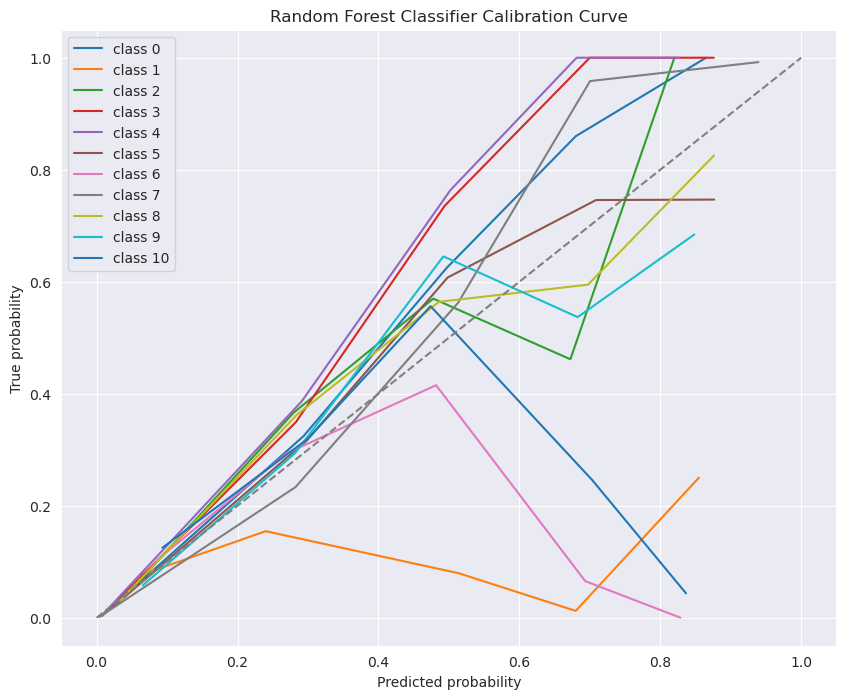

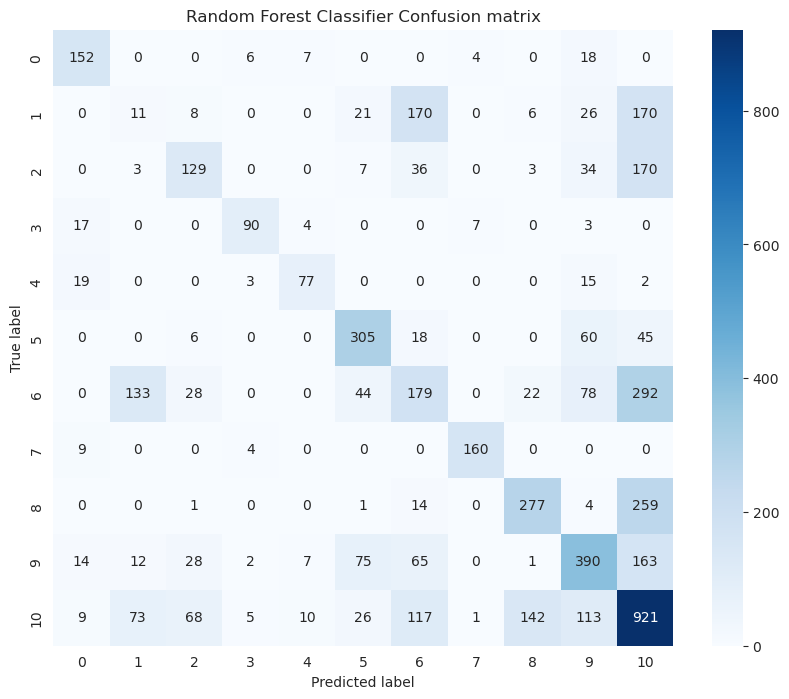

                      Model  Precision    Recall  F1-score
0  Random Forest Classifier    0.48197  0.498426  0.483976


In [33]:
# print logloss validation for train and test predictions
logloss_train_rfc, logloss_test_rfc = calculate_train_test_logloss(y_train, y_train_prob_rfc, y_test, y_test_prob_rfc)

# create a pandas dataframe to store the results
logloss_results_rfc_dict = {'Model': ['Random Forest Classifier'],
                            'Train LogLoss': [logloss_train_rfc],
                            'Test LogLoss': [logloss_test_rfc]}
logloss_results_rfc_df = pd.DataFrame(logloss_results_rfc_dict)
# print logloss result
print(logloss_results_rfc_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Random Forest Classifier',
                                                        'Train LogLoss': logloss_train_rfc,
                                                        'Test LogLoss': logloss_test_rfc}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(rfc, y_test_prob_rfc, "Random Forest Classifier")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_rfc, "Random Forest Classifier")

# precision, recall, f1_score
precision_rfc, recall_rfc, f1_score_rfc, _ = precision_recall_fscore_support(y_test, y_test_pred_rfc, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_rfc_dict = {'Model': ['Random Forest Classifier'],
                                        'Precision': [precision_rfc],
                                        'Recall': [recall_rfc],
                                        'F1-score': [f1_score_rfc]}
precision_recall_f1__results_rfc_df = pd.DataFrame(precision_recall_f1_results_rfc_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_rfc_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Random Forest Classifier',
                                                                                'Precision': precision_rfc,
                                                                                'Recall': recall_rfc,
                                                                                'F1-score': f1_score_rfc}, ignore_index=True)

In [34]:
# Neural Network (Multi-layer perceptron)

# initialize model
neural_net = Sequential()
# define number of features
num_of_features = 18
# define number of classes
num_of_classes = 11
# Input Layer
neural_net.add(Input(shape=(num_of_features,), name='Input-Layer'))
# Hidden Layer 1
neural_net.add(Dense(64, activation='relu', name='Hidden-Layer-1'))
# Hidden Layer 2
neural_net.add(Dense(32, activation='relu', name='Hidden-Layer-2'))
# Output Layer
neural_net.add(Dense(num_of_classes, activation = 'softmax', name='Output-Layer'))
# optimizer to reduce loss
adam = Adam()
# compile model
neural_net.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

# create pipeline to standardize features and create a Multi Layer Perceptron model
mlp = Pipeline([('Standardizer', StandardScaler()), ('mlp', neural_net)])
# one hot encode target train set to work with keras nn
y_train_oh = to_categorical(y_train, 11)
# y_test_oh = to_categorical(y_test, 11)
# fit pipeline to train data
mlp.fit(X_train, y_train_oh, mlp__epochs=100, mlp__batch_size=32,  mlp__class_weight=class_weight_dict)

# Generate predicted probabilities for the train set
y_train_prob_mlp = mlp.predict(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_mlp = mlp.predict(X_test)
# get test predictions
y_test_pred_mlp = np.argmax(y_test_prob_mlp, axis=1)


Epoch 1/100


2023-04-09 00:33:12.632393: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-09 00:33:12.632415: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 00:33:12.632434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emeka-Latitude-5490): /proc/driver/nvidia/version does not exist
2023-04-09 00:33:12.632626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


394/394 [==============================] - 1s 1ms/step - loss: 1.6081 - accuracy: 0.3402
Epoch 2/100
394/394 [==============================] - 1s 1ms/step - loss: 1.2106 - accuracy: 0.4173
Epoch 3/100
394/394 [==============================] - 1s 1ms/step - loss: 1.1510 - accuracy: 0.4391
Epoch 4/100
394/394 [==============================] - 1s 1ms/step - loss: 1.1241 - accuracy: 0.4404
Epoch 5/100
394/394 [==============================] - 1s 1ms/step - loss: 1.1052 - accuracy: 0.4492
Epoch 6/100
394/394 [==============================] - 1s 1ms/step - loss: 1.0882 - accuracy: 0.4500
Epoch 7/100
394/394 [==============================] - 1s 1ms/step - loss: 1.0723 - accuracy: 0.4597
Epoch 8/100
394/394 [==============================] - 1s 1ms/step - loss: 1.0631 - accuracy: 0.4591
Epoch 9/100
394/394 [==============================] - 0s 1ms/step - loss: 1.0555 - accuracy: 0.4610
Epoch 10/100
394/394 [==============================] - 0s 1ms/step - loss: 1.0427 - accuracy: 0.4647
E

                    Model  Train LogLoss  Test LogLoss
0  Multi layer perceptron       1.200304      1.507516


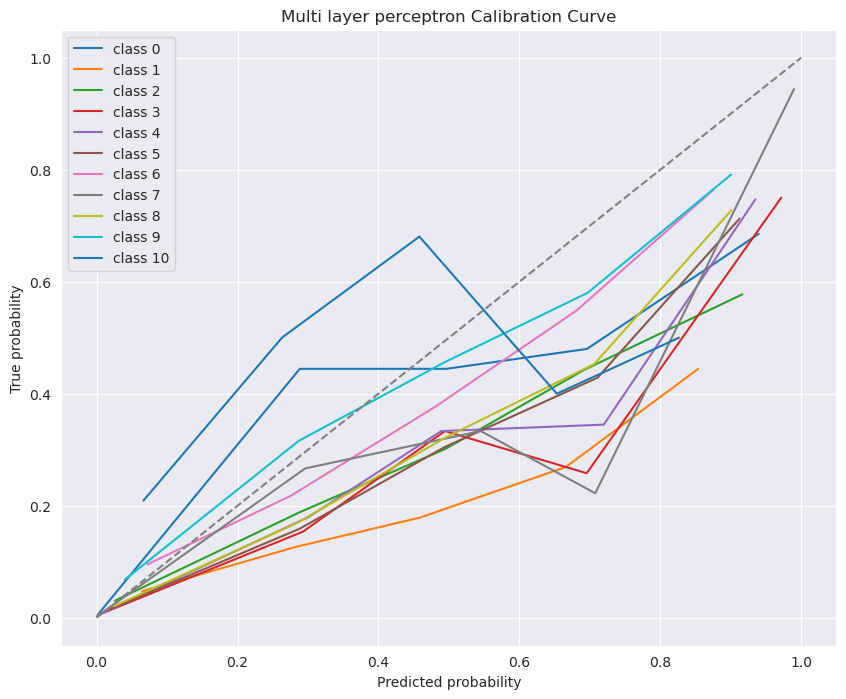

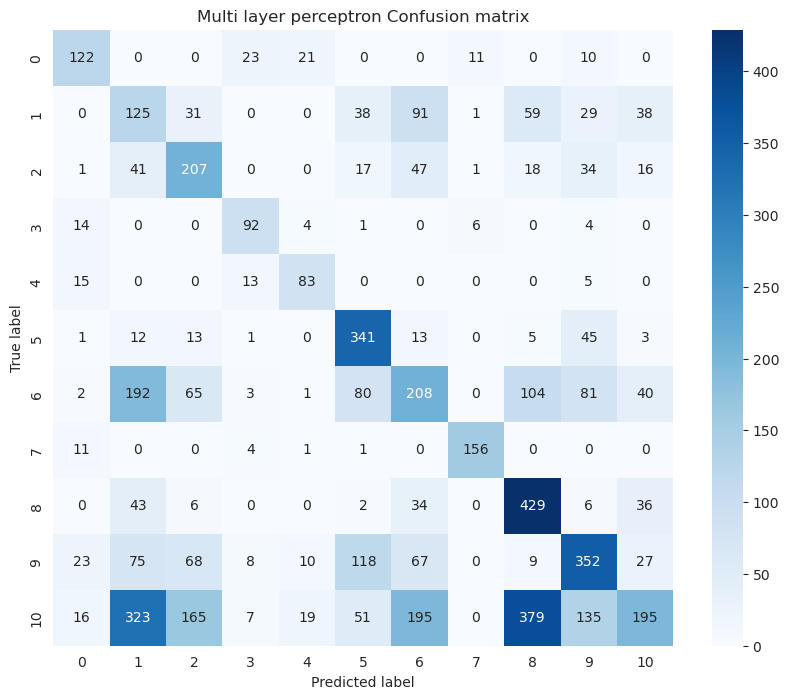

                    Model  Precision    Recall  F1-score
0  Multi Layer Perceptron   0.467228  0.427857  0.401376


In [35]:
# print logloss validation for train and test predictions
logloss_train_mlp, logloss_test_mlp = calculate_train_test_logloss(y_train, y_train_prob_mlp, y_test, y_test_prob_mlp)

# create a pandas dataframe to store the results
logloss_results_mlp_dict = {'Model': ['Multi layer perceptron'],
                            'Train LogLoss': [logloss_train_mlp],
                            'Test LogLoss': [logloss_test_mlp]}
logloss_results_mlp_df = pd.DataFrame(logloss_results_mlp_dict)
# print logloss result
print(logloss_results_mlp_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Multi layer perceptron',
                                                        'Train LogLoss': logloss_train_mlp,
                                                        'Test LogLoss': logloss_test_mlp}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(rfc, y_test_prob_mlp, "Multi layer perceptron")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_mlp, "Multi layer perceptron")

# precision, recall, f1_score
precision_mlp, recall_mlp, f1_score_mlp, _ = precision_recall_fscore_support(y_test, y_test_pred_mlp, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_mlp_dict = {'Model': ['Multi Layer Perceptron'],
                                        'Precision': [precision_mlp],
                                        'Recall': [recall_mlp],
                                        'F1-score': [f1_score_mlp]}
precision_recall_f1__results_mlp_df = pd.DataFrame(precision_recall_f1_results_mlp_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_mlp_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Multi Layer Perceptron',
                                                                                'Precision': precision_mlp,
                                                                                'Recall': recall_mlp,
                                                                                'F1-score': f1_score_mlp}, ignore_index=True)

In [36]:
# test and train log loss for all models
print(logloss_results_all_df)

                       Model  Train LogLoss  Test LogLoss
0        Logistic Regression       1.456761      1.473809
1  Support Vector Classifier       1.162334      1.286531
2   Random Forest Classifier       0.335934      1.546043
3     Multi layer perceptron       1.200304      1.507516


In [37]:
# test precision_recall_f1_results for all models
print(precision_recall_f1_results_all_df)

                       Model  Precision    Recall  F1-score
0        Logistic Regression   0.435661  0.436007  0.413161
1  Support Vector Classifier   0.471420  0.453973  0.435811
2   Random Forest Classifier   0.481970  0.498426  0.483976
3     Multi Layer Perceptron   0.467228  0.427857  0.401376


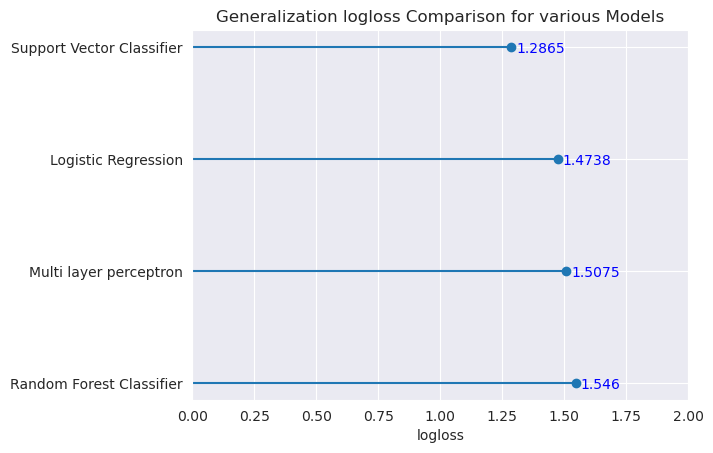

In [38]:
# logloss for generalisation test
EMC = logloss_results_all_df.copy()
EMC.index = ['Logistic Regression', 'Support Vector Classifier', 'Random Forest Classifier', 'Multi layer perceptron']
R2 = round(EMC['Test LogLoss'].sort_values(ascending=False),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('Generalization logloss Comparison for various Models')
plt.xlabel('logloss')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v), color='blue')
    # plt.text(i, v+1, str(v), ha="center")
plt.xlim([0,2])
plt.show()

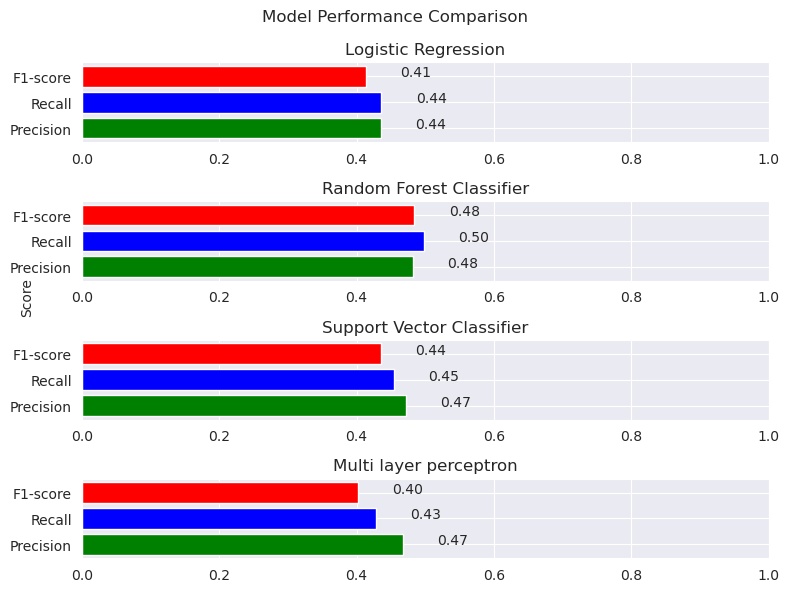

In [42]:
# Create a dictionary to store the precision, recall, and f1-score for each model
scores = {'Logistic Regression': [precision_lr, recall_lr, f1_score_lr],
          'Random Forest Classifier': [precision_rfc, recall_rfc, f1_score_rfc],
          'Support Vector Classifier': [precision_svc, recall_svc, f1_score_svc],
          'Multi layer perceptron': [precision_mlp, recall_mlp, f1_score_mlp]}

# Create a list of the model names and score labels
labels = ['Precision', 'Recall', 'F1-score']
models = list(scores.keys())

# Create a figure with subplots for each model
fig, ax = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 6))

# Iterate over each model and subplot
for i, (model, subplot) in enumerate(zip(models, ax.flatten())):
    # Get the precision, recall, and f1-score for the current model
    model_scores = scores[model]
    # Create a horizontal bar plot for the current model's scores
    subplot.barh(labels, model_scores, color=['green', 'blue', 'red'])
    # Set the subplot title and limits
    subplot.set_title(model)
    subplot.set_xlim([0, 1])
    # Add the score values to the plot
    for j, score in enumerate(model_scores):
        subplot.text(score + 0.05, j, f'{score:.2f}')

# Add a shared y-axis label to the figure
fig.text(0.04, 0.5, 'Score', ha='center', va='center', rotation='vertical')

# Add a figure title and show the plot
fig.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.show()

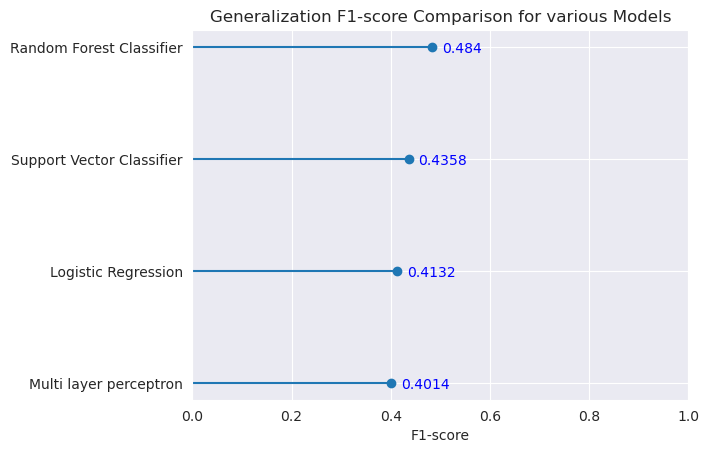

In [40]:
# f1-score for generalisation test
EMC_f1 = precision_recall_f1_results_all_df.copy()
EMC_f1.index = ['Logistic Regression', 'Support Vector Classifier', 'Random Forest Classifier', 'Multi layer perceptron']
f1 = round(EMC_f1['F1-score'].sort_values(ascending=True),4)
plt.hlines(y=f1.index, xmin=0, xmax=f1.values)
plt.plot(f1.values, f1.index,'o')
plt.title('Generalization F1-score Comparison for various Models')
plt.xlabel('F1-score')
for i, v in enumerate(f1):
    plt.text(v+0.02, i-0.05, str(v), color='blue')
    # plt.text(i, v+1, str(v), ha="center")
plt.xlim([0,1])
plt.show()

## Hyper parameter tuning

### Logistic Regression
- tune scaling techniques
- tune PCA
- tune resampling techniques to balance dataset
- Tune hyper parameters

In [43]:
# Define the pipeline
pipe_lr = Pipeline(steps=[
    ('scaler', None),
    ('pca', None),
    ('resampling', None),
    ('logreg', LogisticRegression(multi_class='multinomial', penalty='l2', random_state=42))
])

# Define the parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'pca': [None, PCA(n_components=2), PCA(n_components=3), PCA(n_components=4)],
    'resampling': [None,
                   RandomOverSampler(random_state=42),
                   SMOTE(random_state=42),
                   RandomUnderSampler(random_state=42),
                   BalancedBaggingClassifier(random_state=42),
                   BalancedRandomForestClassifier(random_state=42)],
    'logreg__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__max_iter': [100, 500, 1000],
}

scorer = make_scorer(f1_score, average='weighted')

# Define the grid search
grid_search = GridSearchCV(pipe_lr, param_grid=param_grid, cv=5, scoring=scorer, verbose=4)

# Fit the grid search to the training data
grid_result = grid_search.fit(X_train, y_train)
print('\n Best cv f1-score: {}, using parameters: {}'.format(grid_result.best_score_, grid_result.best_params_))


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV 1/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solver=newton-cg, pca=None, resampling=None, scaler=StandardScaler();, score=0.467 total time=   1.4s
[CV 2/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solver=newton-cg, pca=None, resampling=None, scaler=StandardScaler();, score=0.472 total time=   1.4s
[CV 3/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solver=newton-cg, pca=None, resampling=None, scaler=StandardScaler();, score=0.467 total time=   0.8s
[CV 4/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solver=newton-cg, pca=None, resampling=None, scaler=StandardScaler();, score=0.453 total time=   0.8s
[CV 5/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solver=newton-cg, pca=None, resampling=None, scaler=StandardScaler();, score=0.460 total time=   0.7s
[CV 1/5] END logreg__class_weight=None, logreg__max_iter=100, logreg__solve

In [44]:
# initialise global result dataframe
logloss_results_all_df = pd.DataFrame(columns=['Model', 'Train LogLoss', 'Test LogLoss'])

precision_recall_f1_results_all_df = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1-score'])

In [45]:
# Logistic regression
# Best cv f1-score: 0.46400186407813004,
# using parameters: {
# 'logreg__class_weight': None,
# 'logreg__max_iter': 500,
# 'logreg__solver': 'sag',
# 'pca': None,
# 'resampling': None,
# 'scaler': StandardScaler()}

# building LogisticRegression model with tuned parameters
logisticRegression = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(multi_class='multinomial',
                                  penalty='l2',
                                  max_iter=500,
                                  solver='sag',
                                  random_state=42))
])

# logisticRegression = LogisticRegression(max_iter=1000)
# fit pipeline to train data with standardized features
logisticRegression.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_lr = logisticRegression.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_lr = logisticRegression.predict_proba(X_test)
# get test predictions
y_test_pred_lr = logisticRegression.predict(X_test)

                 Model  Train LogLoss  Test LogLoss
0  Logistic Regression        1.33692       1.35079


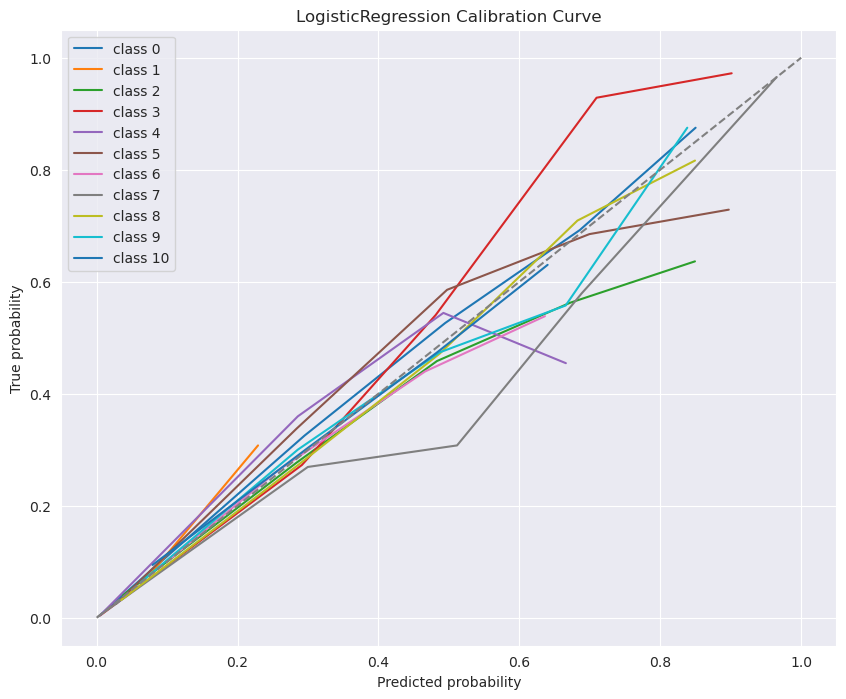

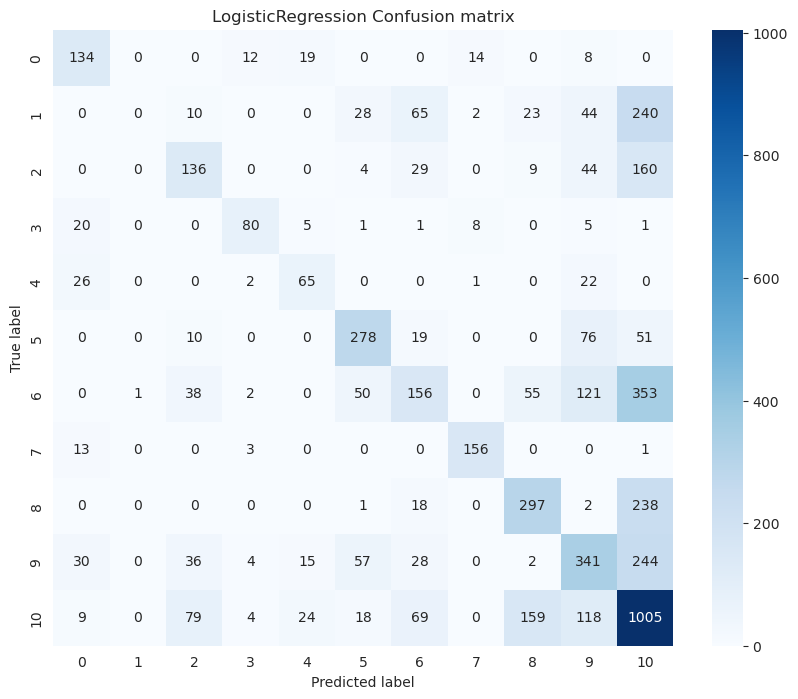

                 Model  Precision    Recall  F1-score
0  Logistic Regression   0.453698  0.490461  0.459428


In [46]:
# print logloss validation for train and test predictions
logloss_train_lr, logloss_test_lr = calculate_train_test_logloss(y_train, y_train_prob_lr, y_test, y_test_prob_lr)

# create a pandas dataframe to store the results
logloss_results_lr_dict = {'Model': ['Logistic Regression'],
                           'Train LogLoss': [logloss_train_lr],
                           'Test LogLoss': [logloss_test_lr]}
logloss_results_lr_df = pd.DataFrame(logloss_results_lr_dict)
# print logloss result
print(logloss_results_lr_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Logistic Regression',
                                                        'Train LogLoss': logloss_train_lr,
                                                        'Test LogLoss': logloss_test_lr}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(logisticRegression, y_test_prob_lr, "LogisticRegression")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_lr, "LogisticRegression")

# precision, recall, f1_score
precision_lr, recall_lr, f1_score_lr, _ = precision_recall_fscore_support(y_test, y_test_pred_lr, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_lr_dict = {'Model': ['Logistic Regression'],
                                       'Precision': [precision_lr],
                                       'Recall': [recall_lr],
                                       'F1-score': [f1_score_lr]}
precision_recall_f1__results_lr_df = pd.DataFrame(precision_recall_f1_results_lr_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_lr_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Logistic Regression',
                                                                                'Precision': precision_lr,
                                                                                'Recall': recall_lr,
                                                                                'F1-score': f1_score_lr}, ignore_index=True)

In [47]:
# Define the pipeline
pipe_svc = Pipeline(steps=[
    ('scaler', None),
    ('pca', None),
    ('resampling', None),
    ('svc', SVC(probability=True, random_state=42))
])

# Define the parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'pca': [None, PCA(n_components=5), PCA(n_components=10), PCA(n_components=20)],
    'resampling': [None,
                   RandomOverSampler(random_state=42),
                   SMOTE(random_state=42),
                   RandomUnderSampler(random_state=42),
                   BalancedBaggingClassifier(random_state=42),
                   BalancedRandomForestClassifier(random_state=42)],
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__class_weight': [None, 'balanced'],
    'svc__max_iter': [100, 500, 1000],
    'svc__C': [0.1, 1, 10],
}

scorer = make_scorer(f1_score, average='weighted')

# Define the grid search
grid_search = GridSearchCV(pipe_svc, param_grid=param_grid, cv=5, scoring=scorer, verbose=4)

# Fit the grid search to the training data
grid_result = grid_search.fit(X_train, y_train)
print('\n Best cv f1-score: {}, using parameters: {}'.format(grid_result.best_score_, grid_result.best_params_))


Fitting 5 folds for each of 2592 candidates, totalling 12960 fits
[CV 1/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.1, svc__class_weight=None, svc__kernel=linear, svc__max_iter=100;, score=0.277 total time=   2.8s
[CV 2/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.1, svc__class_weight=None, svc__kernel=linear, svc__max_iter=100;, score=0.289 total time=   2.8s
[CV 3/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.1, svc__class_weight=None, svc__kernel=linear, svc__max_iter=100;, score=0.234 total time=   2.8s
[CV 4/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.1, svc__class_weight=None, svc__kernel=linear, svc__max_iter=100;, score=0.272 total time=   3.7s
[CV 5/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.1, svc__class_weight=None, svc__kernel=linear, svc__max_iter=100;, score=0.302 total time=   2.9s
[CV 1/5] END pca=None, resampling=None, scaler=StandardScaler(), svc__C=0.

In [48]:
# Support Vector Classifier

# Best cv f1-score: 0.4831260088185466,
# using parameters: {
# 'pca': None,
# 'resampling': None,
# 'scaler': StandardScaler(),
# 'svc__C': 1,
# 'svc__class_weight': None,
# 'svc__kernel': 'rbf',
# 'svc__max_iter': 1000}

# create pipeline to standardize features and create a Support Vector Classifier model with max iteration of 1000
svc = Pipeline([('Standardizer', StandardScaler()), ('SVC', SVC(kernel='rbf', probability=True, random_state=42, max_iter=1000, C=1))])
# svc = SVC(max_iter=1000, kernel='rbf', probability=True)
# fit pipeline to train data minmax scaled features

svc.fit(X_train, y_train)

# Generate predicted probabilities for the train set
y_train_prob_svc = svc.predict_proba(X_train)
# Generate predicted probabilities for the testing set
y_test_prob_svc = svc.predict_proba(X_test)
# get test predictions
y_test_pred_svc = svc.predict(X_test)

                       Model  Train LogLoss  Test LogLoss
0  Support Vector Classifier       1.207034      1.320478


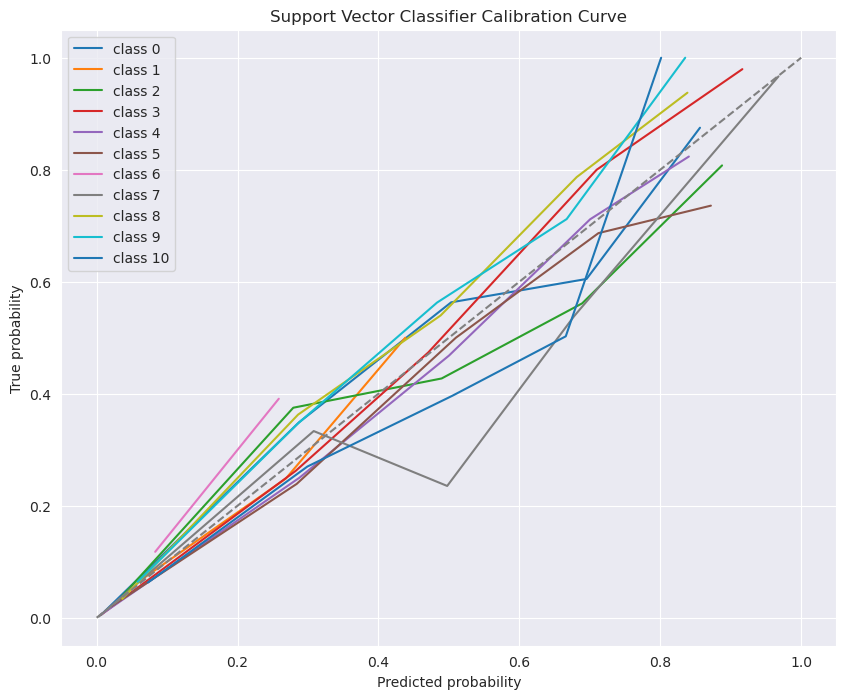

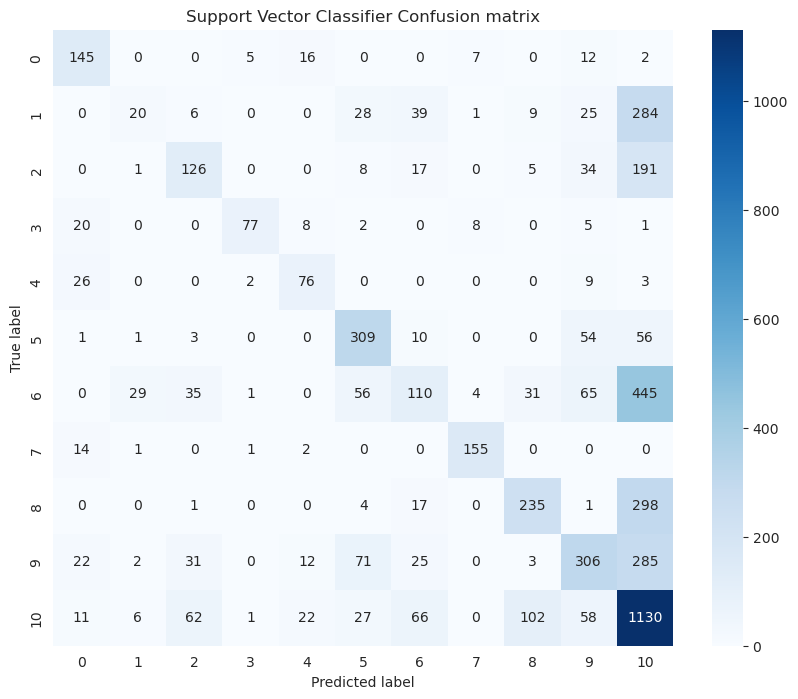

                       Model  Precision    Recall  F1-score
0  Support Vector Classifier   0.498889  0.498055   0.46334


In [49]:
# print logloss validation for train and test predictions
logloss_train_svc, logloss_test_svc = calculate_train_test_logloss(y_train, y_train_prob_svc, y_test, y_test_prob_svc)

# create a pandas dataframe to store the results
logloss_results_svc_dict = {'Model': ['Support Vector Classifier'],
                            'Train LogLoss': [logloss_train_svc],
                            'Test LogLoss': [logloss_test_svc]}
logloss_results_svc_df = pd.DataFrame(logloss_results_svc_dict)
# print logloss result
print(logloss_results_svc_df)

# store the all results in the dataframe
logloss_results_all_df = logloss_results_all_df.append({'Model': 'Support Vector Classifier',
                                                        'Train LogLoss': logloss_train_svc,
                                                        'Test LogLoss': logloss_test_svc}, ignore_index=True)

# plot calibration curve
plot_calibration_curve(svc, y_test_prob_svc, "Support Vector Classifier")

# plot confusion matrix
plot_confusion_matrix(y_test, y_test_pred_svc, "Support Vector Classifier")

# precision, recall, f1_score
precision_svc, recall_svc, f1_score_svc, _ = precision_recall_fscore_support(y_test, y_test_pred_svc, average='weighted')

# create a pandas dataframe to store the results
precision_recall_f1_results_svc_dict = {'Model': ['Support Vector Classifier'],
                                        'Precision': [precision_svc],
                                        'Recall': [recall_svc],
                                        'F1-score': [f1_score_svc]}
precision_recall_f1__results_svc_df = pd.DataFrame(precision_recall_f1_results_svc_dict)
# print precision, recall, f1_score result
print(precision_recall_f1__results_svc_df)

# store the all results in the dataframe
precision_recall_f1_results_all_df = precision_recall_f1_results_all_df.append({'Model': 'Support Vector Classifier',
                                                                                'Precision': precision_svc,
                                                                                'Recall': recall_svc,
                                                                                'F1-score': f1_score_svc}, ignore_index=True)

In [ ]:
# Define the pipeline
pipe_rfc = Pipeline(steps=[
    ('scaler', None),
    ('pca', None),
    ('resampling', None),
    ('rfc',  RandomForestClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],
    'pca': [None, PCA(n_components=5), PCA(n_components=10), PCA(n_components=20)],
    'resampling': [None,
                   RandomOverSampler(random_state=42),
                   SMOTE(random_state=42),
                   RandomUnderSampler(random_state=42),
                   BalancedBaggingClassifier(random_state=42),
                   BalancedRandomForestClassifier(random_state=42)],
    'rfc__n_estimators': [100, 200, 500, 1000],
    'rfc__max_depth': [5, 10, 20, None],
    'rfc__class_weight': [None, 'balanced', 'balanced_subsample'],
    'rfc__max_features': ['sqrt', 'log2'],
}

scorer = make_scorer(f1_score, average='weighted')

# Define the grid search
grid_search = GridSearchCV(pipe_rfc, param_grid=param_grid, cv=5, scoring=scorer, verbose=4)

# Fit the grid search to the training data
grid_result = grid_search.fit(X_train, y_train)
print('\n Best cv f1-score: {}, using parameters: {}'.format(grid_result.best_score_, grid_result.best_params_))
